In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# MODELLING

The gene expression data will be investigated hoping to find clusters, which are representative for the histology of cancertype. Further, we can investigate whether there are different patterns for male and females and whether the tumor size has an impact on which genes are expressed.

## Data preparation
Data was checked for skewness and then transformed to be normal shaped. Standardization was conducted as preparation step for dimensionality reduction.

## Dimensionality reduction
The following techniques were considered:
- PCA
- MDS
- spectral embedding
- spectral clustering
- tSNE

## Clustering
Clustering techniques discussed:
- k-means
- Hierarchical agglomerative clustering
- DBSCAN

## Load concatenated dataset

In [7]:
df = pd.read_csv('Clinical_Gene_Exp.csv')

In [8]:
df.head()

,Unnamed: 0,characteristics.tag.histology,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter,"('AFFX-BioB-3_at',)","('AFFX-BioB-5_at',)","('AFFX-BioB-M_at',)","('AFFX-BioC-3_at',)","('AFFX-BioC-5_at',)",...,"('merck2-Z41436_at',)","('merck2-Z43503_at',)","('merck2-Z47244_x_at',)","('merck2-Z47250_x_at',)","('merck2-Z48501_s_at',)","('merck2-Z48633_s_at',)","('merck2-Z70222_a_at',)","('merck2-Z70608_x_at',)","('merck2-Z72499_a_at',)","('merck2-Z75331_a_at',)"
0,0,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,0,4.0,7.376915,6.984530,7.330576,10.922741,11.032030,...,7.077955,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069
1,1,"Adenocarcinoma, Papillary, NOS",Left Lower Lobe,0,1.3,8.024915,7.427048,8.010530,11.390638,11.533338,...,7.552333,3.578359,5.516440,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508
2,2,Non-Small Cell,Left Lower Lobe,0,11.0,7.522543,7.077207,7.334551,10.936703,11.018510,...,5.084856,2.937384,6.310065,6.315107,11.584115,10.586540,6.112918,1.753519,9.515653,6.556233
3,3,"Papillary Type AND Adenocarcinoma, Bronch...",Left Lower Lobe,0,3.5,7.152864,6.849513,7.143286,10.791909,10.875259,...,7.136409,2.904756,5.954062,6.738276,11.240300,10.257621,6.276813,1.889742,9.383670,7.293852
4,4,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,1,7.8,7.211031,6.753131,7.077163,10.701328,10.823792,...,7.667150,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336


## Prepare the data
Extract the features, which shall be used for clustering from the ones, which can be used for colour coding.

In [9]:
# extract and store the color coding variables
labels = df.iloc[:, 1:5]
labels.head()

,characteristics.tag.histology,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter
0,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,0,4.0
1,"Adenocarcinoma, Papillary, NOS",Left Lower Lobe,0,1.3
2,Non-Small Cell,Left Lower Lobe,0,11.0
3,"Papillary Type AND Adenocarcinoma, Bronch...",Left Lower Lobe,0,3.5
4,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,1,7.8


In [10]:
# check which labels exist
labels['characteristics.tag.histology'].unique()

array(['Squamous Cell Carcinoma, NOS', 'Adenocarcinoma, Papillary, NOS',
       'Non-Small Cell',
       'Papillary Type AND \xa0\xa0\xa0\xa0 Adenocarcinoma, Bronchiolo-alveolar Features',
       'Adenocarcinoma, NOS', 'Solid Type And Acinar',
       'Adenocarcinoma, Mixed',
       'Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features',
       'Adenocarcinoma, Acinar Type',
       'Squamous Cell Carcinoma, Other (Specify) with adeno features',
       'Adenocarcinoma With Mucinous Features',
       'Adenocarcinoma, Bronchiolo-alveolar Features',
       'Adenocarcinoma With Papillary Features',
       'Carcinoma, Large Cell, Neuroendocrine',
       'Squamous Cell Carcinoma, Other (Specify)endobronchial',
       'Squamous Cell Carcinoma, Papillary',
       'Non-Small Cell, Pleomorphic Type'], dtype=object)

There are three main types: squamous cell carcinoma and adenocarcinoma with histological subtypes and Non-Small Cell carcinoma. A fourth small group with other types is present as well. It might be interesting to conduct hierarchical chlustering to see how the relation between histology subtypes is based on the patterns found with clustering algorithm. From the labelling the assumption would be to see three separated clusters with maybe subclusters. Therfore an additional column is introduced with only squamous cell carcinoma and adenocarcinoma.

Furthermore, the location of the tumor, the gender and the diameter of the tumor could play a role in cluster generation and are therefore used for later on color-coding.

In [11]:
# group labels in bigger group based on similarity in their naming
labels['hist_tags'] = labels['characteristics.tag.histology'].str.extract('(Squamous Cell Carcinoma|Adenocarcinoma|Non-Small Cell)', expand=True)
labels.head()

,characteristics.tag.histology,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter,hist_tags
0,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,0,4.0,Squamous Cell Carcinoma
1,"Adenocarcinoma, Papillary, NOS",Left Lower Lobe,0,1.3,Adenocarcinoma
2,Non-Small Cell,Left Lower Lobe,0,11.0,Non-Small Cell
3,"Papillary Type AND Adenocarcinoma, Bronch...",Left Lower Lobe,0,3.5,Adenocarcinoma
4,"Squamous Cell Carcinoma, NOS",Left Lower Lobe,1,7.8,Squamous Cell Carcinoma


In [12]:
# find the small group with 'other' types
labels[labels.hist_tags.isnull()]

,characteristics.tag.histology,source.location,characteristics.tag.gender,characteristics.tag.tumor.size.maximumdiameter,hist_tags
8,Solid Type And Acinar,Right Lower Lobe,0,4.2,NaN
9,Solid Type And Acinar,Left Upper Lobe,0,6.2,NaN
59,"Carcinoma, Large Cell, Neuroendocrine",Right Lower Lobe,1,7.2,NaN


In [13]:
# call them others
labels.fillna('other',inplace=True)

In [14]:
# assign the features (gene expression data) to separate dataframe
data = df.iloc[:, 5:]
data.head()

,"('AFFX-BioB-3_at',)","('AFFX-BioB-5_at',)","('AFFX-BioB-M_at',)","('AFFX-BioC-3_at',)","('AFFX-BioC-5_at',)","('AFFX-BioDn-3_at',)","('AFFX-BioDn-5_at',)","('AFFX-BkGr-GC03_at',)","('AFFX-BkGr-GC04_at',)","('AFFX-BkGr-GC05_at',)",...,"('merck2-Z41436_at',)","('merck2-Z43503_at',)","('merck2-Z47244_x_at',)","('merck2-Z47250_x_at',)","('merck2-Z48501_s_at',)","('merck2-Z48633_s_at',)","('merck2-Z70222_a_at',)","('merck2-Z70608_x_at',)","('merck2-Z72499_a_at',)","('merck2-Z75331_a_at',)"
0,7.376915,6.984530,7.330576,10.922741,11.032030,13.411168,12.625445,1.464847,1.416673,1.438285,...,7.077955,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069
1,8.024915,7.427048,8.010530,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,1.403564,...,7.552333,3.578359,5.516440,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508
2,7.522543,7.077207,7.334551,10.936703,11.018510,13.360017,12.540647,1.355337,1.343599,1.306212,...,5.084856,2.937384,6.310065,6.315107,11.584115,10.586540,6.112918,1.753519,9.515653,6.556233
3,7.152864,6.849513,7.143286,10.791909,10.875259,13.364171,12.579293,1.327548,1.272961,1.354529,...,7.136409,2.904756,5.954062,6.738276,11.240300,10.257621,6.276813,1.889742,9.383670,7.293852
4,7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,1.291959,...,7.667150,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336


## Data preparation
Check the distributions. For gene expression data a skeweness in the distribution can occur when a gene is normally not expressed but due to special circumstances it is very high expressed. This especially is the case for cancerous cells expression. Therefore the data is checked for skewness and then transformed if necessary. Afterwards standardization is conducted.

In [15]:
#check for skewness in the data and write the column names to list
skew_columns = (data.skew().sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
len(skew_columns.index)

16116

In [16]:
# extract columns from dataset which require transformation
to_transform = data[skew_columns.index]
to_transform

,"('merck-NC_001526_ORF_1178_at',)","('merck-NC_001526_ORF_1180_at',)","('merck-NC_001526_ORF_1182_at',)","('merck-BX648957_at',)","('merck-NC_001526_ORF_1179_at',)","('merck-NM_003284_s_at',)","('merck-BC067883_at',)","('merck-AK130854_at',)","('merck-BC045546_at',)","('merck-NM_003008_at',)",...,"('merck2-BG503223_at',)","('merck2-AL831965_x_at',)","('merck2-BC128418_at',)","('merck-XM_379424_at',)","('merck2-CB988589_at',)","('merck-NM_152539_at',)","('merck-ENST00000378906_at',)","('merck-AK127029_at',)","('merck2-AL713762_at',)","('merck2-BE222032_at',)"
0,1.751089,1.923739,1.779409,2.947517,2.166352,3.129840,1.891794,2.212246,1.981491,2.192580,...,1.861109,3.530079,5.139286,2.439108,4.038099,2.375657,4.644862,2.282349,2.654022,3.728412
1,1.734086,2.036465,2.421049,2.638011,2.422869,3.315131,1.806821,2.226301,1.757842,2.527742,...,1.898473,3.235672,5.322348,2.438386,3.593132,3.515497,4.833261,1.982835,2.325837,3.256609
2,1.713741,2.117503,1.900508,3.008557,2.230895,3.585259,1.819067,2.417597,9.596876,2.060241,...,1.750539,3.427685,5.369649,2.443685,3.477359,2.580502,4.828437,1.738827,2.971469,3.756250
3,1.430930,2.036134,1.898905,2.560518,1.945517,3.460781,1.738263,2.041107,1.916549,2.250460,...,1.562808,2.450362,6.435685,2.630789,3.659406,2.521466,4.464399,1.744224,3.935132,3.319397
4,9.513824,10.727684,8.923205,2.747191,9.735626,3.443854,1.602254,2.068401,1.584063,8.464755,...,1.738284,4.933662,5.478771,2.554018,4.622671,2.735747,4.542463,1.875170,3.185894,3.756722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.861992,1.954489,2.087652,2.622204,1.905323,3.090534,1.791824,2.370415,1.704223,2.193021,...,1.805556,3.140600,5.444808,2.663773,3.673200,2.839320,4.273460,1.561808,3.427227,3.794744
85,1.897688,2.309729,1.995183,2.574371,1.835827,3.536945,1.635466,2.035348,1.687369,2.080671,...,1.809376,3.256154,5.569662,2.688792,4.508171,2.395854,4.615754,2.118412,4.893751,3.584508
86,1.731126,2.125028,1.896516,2.508667,2.334790,3.331077,1.538350,2.482759,2.040027,1.778554,...,1.784179,3.208765,4.962811,2.647916,4.053721,2.270624,4.951484,2.011435,3.154695,3.219972
87,1.811532,2.522141,2.028475,3.182315,1.872325,3.034610,1.503894,2.375632,1.726513,2.667143,...,1.748919,5.646401,5.756024,2.322542,4.833163,2.517216,4.896159,1.568157,4.135101,3.748645


In [17]:
# get the column names which do not require transformation
all_values = set(data.columns)
skew_set = set(skew_columns.index)
not_skew_set = all_values - skew_set
not_skew = list(not_skew_set)
len(not_skew)

44491

In [18]:
# get data which does not require transformation
not_transform = data[not_skew]
not_transform

,"('merck-BF768564_at',)","('merck2-AW051779_at',)","('merck-AK023773_at',)","('merck-BC003676_a_at',)","('merck-NM_000946_at',)","('merck-NM_001243_at',)","('merck2-BC028232_x_at',)","('merck-hCT8852.2_at',)","('merck-XM_939870_at',)","('merck-BI821833_at',)",...,"('merck-ENST00000326989_at',)","('merck-AW976351_at',)","('merck2-BC019010_at',)","('merck2-BC030582_at',)","('merck-NM_001034841_at',)","('merck-XM_352159_x_at',)","('merck-NM_021052_at',)","('merck2-ENST00000361503_s_at',)","('merck-XM_089258_at',)","('merck-NM_016058_at',)"
0,3.839195,4.631633,5.193927,9.405266,7.099327,5.252235,4.242723,4.985578,4.043898,3.701099,...,3.562245,5.040085,3.631755,6.639141,5.679361,8.526547,8.357784,7.546902,2.418600,9.496137
1,4.179076,4.940239,5.506017,10.256288,6.174765,5.313735,4.919280,5.186924,4.475820,3.985604,...,4.261944,3.235618,3.382032,4.856734,6.420489,9.133190,7.749870,10.840863,2.167505,7.787792
2,3.824215,4.615649,5.226846,9.447380,7.456936,4.628464,4.895073,5.429237,5.015526,4.185277,...,4.284606,4.464455,4.054509,6.162605,5.987692,8.798698,8.227718,8.997617,2.404805,9.300325
3,3.804264,4.866143,5.444615,8.560092,6.536854,4.746920,4.652553,5.095837,4.127316,3.956264,...,3.542002,4.390715,3.488744,6.102990,5.842597,8.765822,4.402102,11.645271,1.906238,8.681313
4,4.436665,4.658054,5.529097,8.944949,7.265322,5.930771,4.898535,5.530328,4.309743,4.019205,...,4.153506,3.383040,4.554669,5.861697,6.184206,8.527122,6.874287,9.978521,2.095344,9.003428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,3.976088,4.713615,5.548562,8.981005,6.232888,5.384099,4.965541,5.023723,3.592662,3.759585,...,3.793019,4.811792,4.255086,6.126170,6.051280,8.557168,7.015856,11.198129,2.105079,8.540629
85,4.009611,5.104726,5.423314,9.696784,6.483352,5.442674,4.920959,5.307534,3.868912,3.949411,...,3.917586,3.723178,4.152361,6.692158,6.206515,8.085919,4.585284,9.853478,2.190881,9.082670
86,3.692736,4.766121,5.201510,9.203348,8.418948,5.217716,4.053721,5.144564,3.900209,3.697552,...,3.603164,4.465182,3.669938,6.750921,5.760697,8.606852,8.097311,6.431314,2.049249,9.608173
87,4.012960,4.853452,5.431904,8.726131,7.038078,5.445793,5.043732,4.862596,4.594236,3.874623,...,4.041439,3.301754,3.817968,6.795959,6.094823,8.310360,9.797341,12.823518,2.524053,9.179030


As previously seen, the data is strongly shifted to the left side. To shift the data towards normal distribution either log transformation or power transform can be used. Here I am using Yeo-Johnson (default, which allows to handle 0s and negative values) transformation (Power transform from scikit learn). Transformation is conducted in place.

In [19]:
# conduct yeo-johnson power transform
power_transform(to_transform, method = 'yeo-johnson', copy = False)

C:\Users\chiar\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[ 0.03038148, -1.54681499, -1.83120456, ...,  1.60454794,
        -1.08818059,  0.06213251],
       [-0.0811749 , -0.67534248,  1.65553644, ...,  0.41889106,
        -2.00593658, -1.70170671],
       [-0.22015815, -0.15896177, -0.75523945, ..., -0.98945414,
        -0.33794457,  0.14948761],
       ...,
       [-0.10101654, -0.11500139, -0.78613669, ...,  0.5539392 ,
         0.04543743, -1.86506428],
       [ 0.3956926 ,  1.51647973,  0.10216502, ..., -2.33409513,
         1.65252595,  0.12578364],
       [-0.92815969,  0.68800017, -0.73660548, ...,  0.54180425,
        -0.67854643,  1.00664129]])

In [20]:
# quick check of the values
to_transform

,"('merck-NC_001526_ORF_1178_at',)","('merck-NC_001526_ORF_1180_at',)","('merck-NC_001526_ORF_1182_at',)","('merck-BX648957_at',)","('merck-NC_001526_ORF_1179_at',)","('merck-NM_003284_s_at',)","('merck-BC067883_at',)","('merck-AK130854_at',)","('merck-BC045546_at',)","('merck-NM_003008_at',)",...,"('merck2-BG503223_at',)","('merck2-AL831965_x_at',)","('merck2-BC128418_at',)","('merck-XM_379424_at',)","('merck2-CB988589_at',)","('merck-NM_152539_at',)","('merck-ENST00000378906_at',)","('merck-AK127029_at',)","('merck2-AL713762_at',)","('merck2-BE222032_at',)"
0,0.030381,-1.546815,-1.831205,1.281970,0.450178,-1.408027,1.053844,-0.169766,1.017636,0.676342,...,1.254614,-0.015842,-1.443560,-1.158345,0.555936,-1.392791,-0.272438,1.604548,-1.088181,0.062133
1,-0.081175,-0.675342,1.655536,0.002492,1.243819,-0.308315,0.726157,-0.088928,0.047040,1.618912,...,1.440834,-0.412405,-0.754943,-1.163520,-0.595960,2.373331,0.387752,0.418891,-2.005937,-1.701707
2,-0.220158,-0.158962,-0.755239,1.460285,0.679632,0.818967,0.776551,0.794405,2.693263,0.118111,...,0.645397,-0.147643,-0.590120,-1.125685,-0.973289,-0.442521,0.372198,-0.989454,-0.337945,0.149488
3,-2.985849,-0.677620,-0.767611,-0.452364,-0.538880,0.356615,0.421995,-1.395387,0.786793,0.880985,...,-0.631961,-1.810515,2.088980,0.054504,-0.396326,-0.699375,-1.021011,-0.952484,1.374020,-1.431750
4,3.636017,3.503463,3.246591,0.539143,3.433328,0.286771,-0.312070,-1.165640,-1.181490,3.135214,...,0.572014,1.323296,-0.228591,-0.395343,1.572380,0.175512,-0.681719,-0.141355,0.107542,0.150957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.667016,-1.289084,0.424359,-0.084846,-0.760770,-1.686949,0.662880,0.609406,-0.275594,0.677983,...,0.959976,-0.552812,-0.338404,0.234691,-0.356170,0.546622,-1.965368,-2.391513,0.559836,0.267684
85,0.842553,0.789553,-0.098091,-0.365951,-1.182171,0.649672,-0.114605,-1.445803,-0.386367,0.213545,...,0.980954,-0.382997,0.053864,0.366470,1.406044,-1.291358,-0.384876,1.014532,2.545262,-0.416232
86,-0.101017,-0.115001,-0.786137,-0.797505,1.004784,-0.227977,-0.730681,1.021305,1.198104,-1.672979,...,0.840557,-0.451485,-2.192890,0.148999,0.589336,-1.951068,0.748968,0.553939,0.045437,-1.865064
87,0.395693,1.516480,0.102165,1.876268,-0.954592,-2.116518,-0.979832,0.630794,-0.136174,1.879004,...,0.635767,1.782442,0.585023,-2.062037,1.845539,-0.718370,0.584580,-2.334095,1.652526,0.125784


In [21]:
# concatenate the two subsets and standardize
data1 = pd.concat([to_transform, not_transform], axis = 1)
data1.head()

,"('merck-NC_001526_ORF_1178_at',)","('merck-NC_001526_ORF_1180_at',)","('merck-NC_001526_ORF_1182_at',)","('merck-BX648957_at',)","('merck-NC_001526_ORF_1179_at',)","('merck-NM_003284_s_at',)","('merck-BC067883_at',)","('merck-AK130854_at',)","('merck-BC045546_at',)","('merck-NM_003008_at',)",...,"('merck-ENST00000326989_at',)","('merck-AW976351_at',)","('merck2-BC019010_at',)","('merck2-BC030582_at',)","('merck-NM_001034841_at',)","('merck-XM_352159_x_at',)","('merck-NM_021052_at',)","('merck2-ENST00000361503_s_at',)","('merck-XM_089258_at',)","('merck-NM_016058_at',)"
0,0.030381,-1.546815,-1.831205,1.281970,0.450178,-1.408027,1.053844,-0.169766,1.017636,0.676342,...,3.562245,5.040085,3.631755,6.639141,5.679361,8.526547,8.357784,7.546902,2.418600,9.496137
1,-0.081175,-0.675342,1.655536,0.002492,1.243819,-0.308315,0.726157,-0.088928,0.047040,1.618912,...,4.261944,3.235618,3.382032,4.856734,6.420489,9.133190,7.749870,10.840863,2.167505,7.787792
2,-0.220158,-0.158962,-0.755239,1.460285,0.679632,0.818967,0.776551,0.794405,2.693263,0.118111,...,4.284606,4.464455,4.054509,6.162605,5.987692,8.798698,8.227718,8.997617,2.404805,9.300325
3,-2.985849,-0.677620,-0.767611,-0.452364,-0.538880,0.356615,0.421995,-1.395387,0.786793,0.880985,...,3.542002,4.390715,3.488744,6.102990,5.842597,8.765822,4.402102,11.645271,1.906238,8.681313
4,3.636017,3.503463,3.246591,0.539143,3.433328,0.286771,-0.312070,-1.165640,-1.181490,3.135214,...,4.153506,3.383040,4.554669,5.861697,6.184206,8.527122,6.874287,9.978521,2.095344,9.003428


In [22]:
# make data matrix
X = data.values

In [23]:
# check shape and datatype
print(X.shape)
X.dtype

(89, 60607)


dtype('float64')

In [24]:
# standardize X
X = StandardScaler().fit_transform(X)

## Dimensionality Reduction

Gene expression data is high dimensional, big data. To visualise the data and to form clusters a reduction of the dimensionality is required. The standard procedure seems to be PCA [10.1016/s0025-5564(01)00106-7, https://link.springer.com/chapter/10.1007/978-81-322-2538-6_51], however this might not necessarily be the optimal choice but just the best known strategy amonst biologists. Therefore, several different techniques are explored.

The gene expression data for this project was acquired using affymetrix microchips. This technology has the following drawbacks:
- only known genes (for which markers are coated to the well) are detected and measured
- we measure intensities, for very high intensities there could be blending out artificats arise for the genes coated to the neighboring area
This two sources of inaccurracy may introduce noise and may impede the analysis. It might decrease the covariances, which affects the PCA outcome as well as decreases the distance in intensity levels of close to each other coated genes. Keeping this in mind, several dimensionality reduction techniques are tested. 

Dimensionality reduction:
- PCA (reduce to 2 dimensions to visualize, reduce to as many principle components are needed to explain 85% of the variance and use all these components as input for clustering)
- Multidmensional scaling
- Spectral embedding
- tSNE

### PCA

In [25]:
## PCA
pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
print(principalDf.shape)

(89, 57)


C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:xlabel='0', ylabel='1'>

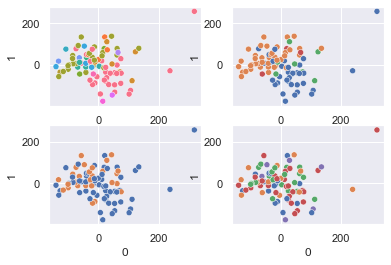

In [27]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(principalDf[0], principalDf[1], hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(principalDf[0], principalDf[1], hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(principalDf[0], principalDf[1], hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(principalDf[0], principalDf[1], hue = labels['source.location'], legend = False, ax=axes[1,1])

C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:xlabel='1', ylabel='2'>

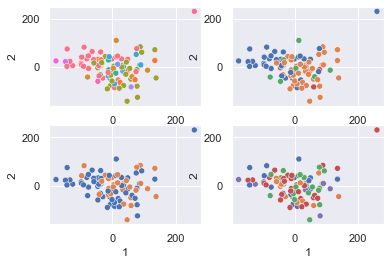

In [28]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(principalDf[1], principalDf[2], hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(principalDf[1], principalDf[2], hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(principalDf[1], principalDf[2], hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(principalDf[1], principalDf[2], hue = labels['source.location'], legend = False, ax=axes[1,1])

C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:xlabel='0', ylabel='2'>

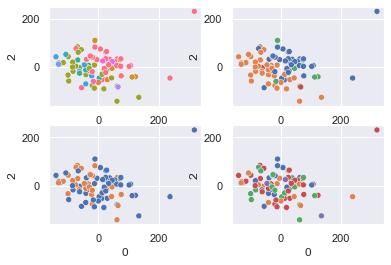

In [29]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(principalDf[0], principalDf[2], hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(principalDf[0], principalDf[2], hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(principalDf[0], principalDf[2], hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(principalDf[0], principalDf[2], hue = labels['source.location'], legend = False, ax=axes[1,1])

Combinations of the first thre pricncipal components with color coding (top left: original histology label, top right: relabeled histology, bottom left: gender, bottom right: tumor location) where visualised. Ther are no clear separations seen. However, there is one more distant point in the top right corner visible.

### MDS

In [30]:
MDS_reduction = MDS(n_components=10, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=42,
dissimilarity='euclidean')

MDS_reduction


X_mds = MDS_reduction.fit_transform(X)
X_mds.shape
X_mds[:,:1].ravel().shape

(89,)

C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:>

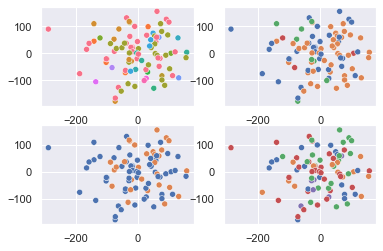

In [31]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,1:2].ravel(), hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,1:2].ravel(), hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,1:2].ravel(), hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,1:2].ravel(), hue = labels['source.location'], legend = False, ax=axes[1,1])

C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:>

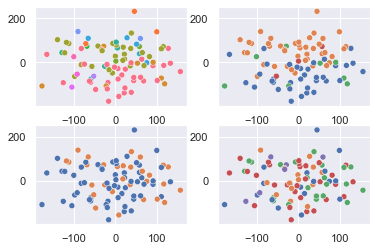

In [32]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(X_mds[:,1:2].ravel(), X_mds[:,2:3].ravel(), hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(X_mds[:,1:2].ravel(), X_mds[:,2:3].ravel(), hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(X_mds[:,1:2].ravel(), X_mds[:,2:3].ravel(), hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(X_mds[:,1:2].ravel(), X_mds[:,2:3].ravel(), hue = labels['source.location'], legend = False, ax=axes[1,1])

C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\chiar\anacond

<AxesSubplot:>

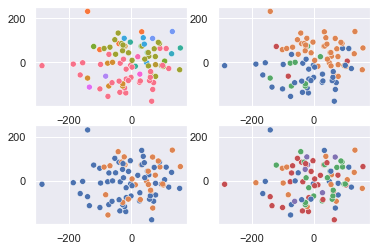

In [33]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,2:3].ravel(), hue = labels['characteristics.tag.histology'], legend = False, ax=axes[0,0])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,2:3].ravel(), hue = labels['hist_tags'], legend = False, ax=axes[0,1])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,2:3].ravel(), hue = labels['characteristics.tag.gender'], legend = False, ax=axes[1,0])
sns.scatterplot(X_mds[:,:1].ravel(), X_mds[:,2:3].ravel(), hue = labels['source.location'], legend = False, ax=axes[1,1])

For multidimensional scaling no separation can be seen from visualising 2 components. Clustering will be performed on 10 components.

### Spectal embedding
AKA a first step towards UMAP

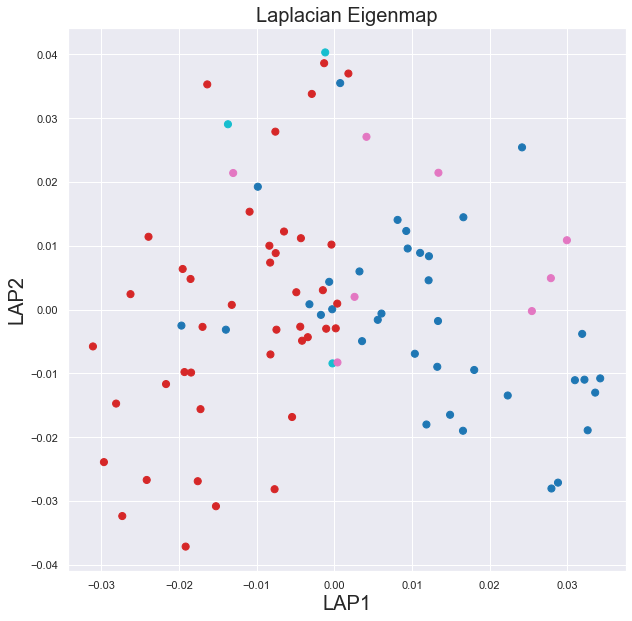

In [35]:
spec_emb = SpectralEmbedding(n_components = 2, n_neighbors = 50)
se = spec_emb.fit_transform(X)
se
plt.figure(figsize=(10,10))
plt.scatter(se[:, 0], se[:, 1], c = labels.hist_tags.map({'Squamous Cell Carcinoma':1, 'Adenocarcinoma':2, 'Non-Small Cell':3, 'other':4}), cmap = 'tab10', s = 50)
plt.title('Laplacian Eigenmap', fontsize = 20)
plt.xlabel("LAP1", fontsize = 20)
plt.ylabel("LAP2", fontsize = 20)
plt.show()

Kind of separatin of red and blue group visible.

### tSNE
Most promsing approach next to PCA

In [36]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', random_state = 42)
#fit 
X_embedded = X_embedded.fit_transform(X)
# produced an two dimension array with x,y features for every row, since n_components = 2
X_embedded.shape

(89, 2)

In [37]:
def plot_cluster(X, df):
    #add x, y features to the original df
    df['x'] = X[:,0]
    df['y'] = X[:,1]
    sns.scatterplot(x = 'x', y = 'y', hue = labels.hist_tags, data = df, alpha = 0.5, palette=['red','blue', 'green','pink'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

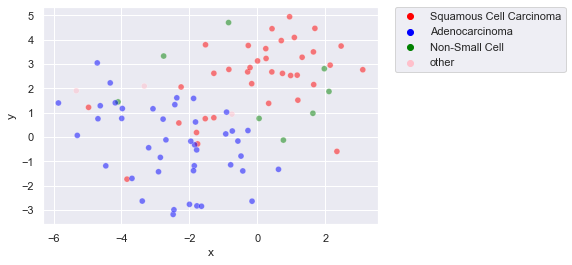

In [38]:
plot_cluster(X_embedded, data)

Mist visible separation so far. The squamous cell carcinoma seems to have more overlap with the other and non-small cell carcinoma than the Adenocarcinoma

## Dimensionality reduction and clustering in one go: SPECTRAL GRAPH CLUSTERING
I thought this could be an interesting alternative, due to measuring distances and considering cliques.

In [41]:
#spectral graph partitoning
spec_clustering = SpectralClustering(n_clusters=4,
         assign_labels='discretize',
         random_state=0).fit(X)

print(spec_clustering.labels_)

[2 1 1 2 0 1 3 1 1 0 0 2 0 0 1 1 1 0 2 1 3 0 1 1 3 2 1 0 2 2 2 2 2 0 0 2 0
 1 0 2 0 1 3 0 2 1 2 0 2 2 0 3 3 3 0 1 0 3 3 2 0 3 1 1 2 1 2 2 3 3 1 0 1 0
 3 0 2 3 1 2 3 0 1 2 0 1 0 1 3]


C:\Users\chiar\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


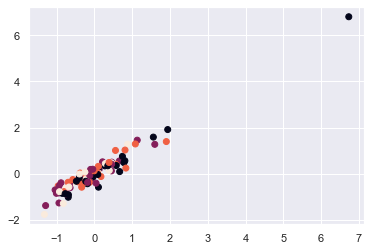

In [42]:
plt.scatter(X[:,0], X[:,1], c=spec_clustering.labels_)

Not sure what that means, but it certainly does not look like there are clear locations where to split the graph into clusters.

## Clustering
### k-means

In [44]:
# instantiate k means clustering with 4 clussters
kmeans = KMeans(n_clusters=4, random_state=0, init = 'k-means++')

In [57]:
# fit the data
def fit_evaluate_kmeans(name, data):
    #fitting
    kmeans_fit = kmeans.fit_predict(data)
    
    # evaluation using adjusted rand index
    k_means_ev = metrics.adjusted_rand_score(kmeans_fit, labels.hist_tags.values)
    print('Adjusted clustering score kmeans on', name, 'for regrouped labels: {:0.3f}'.format(k_means_ev))

In [61]:
# fit original dataset and reduced ones
dr = ['original', 'PCA', 'MDS', 'spec_emb', 'tsne']
data_ls = [X, principalDf, X_mds, se, X_embedded]

for name, dataset in zip(dr, data_ls):
    fit_evaluate_kmeans(name, dataset)

Adjusted clustering score kmeans on original for regrouped labels: 0.374
Adjusted clustering score kmeans on PCA for regrouped labels: 0.280
Adjusted clustering score kmeans on MDS for regrouped labels: 0.276
Adjusted clustering score kmeans on spec_emb for regrouped labels: 0.139
Adjusted clustering score kmeans on tsne for regrouped labels: 0.291


Thes adjusted rand index is pretty low for all chosen methods. The higher the index the better the methods. This might point to, that there is overlap and similar patterns for the subhistology types which makes separation of all subtypes impossible with this technique and the amount of samples per class.

In [114]:
print(labels.groupby('hist_tags')['hist_tags'].count())
print(labels.groupby('characteristics.tag.histology')['characteristics.tag.histology'].count())

hist_tags
Adenocarcinoma             42
Non-Small Cell              8
Squamous Cell Carcinoma    36
other                       3
Name: hist_tags, dtype: int64
characteristics.tag.histology
Adenocarcinoma With Mucinous Features                                    1
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma, Acinar Type                                              3
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Mixed                                                    1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features               1
Adenocarcinoma, NOS                                                     25
Adenocarcinoma, Papillary, NOS                                           4
Carcinoma, Large Cell, Neuroendocrine                                    1
Non-Small Cell                                                           7
Non-Small Cell, Pleomorphic Type                            

The expected clusters would vary a lot in size, which might lead to non spheric shapes, which can lead to poor performance of the k-means clustering. Other clustering techniques to try could be hierarchical clustering, DBSCAN, spectral clustering. DBSCAN is probably not optimal choice, since it is based on density, which is way more unlikely to achieve for the smaller groups than the bigger groups, which makes them likely to be marked as outliers rather than clusters. Spectral clustering did not perform well as already demonstrated. Hierachical clustering is performed on the PCA data in the following:

### Hierarchical clustering

In [63]:
HAC = AgglomerativeClustering(n_clusters = 4,
                              affinity ='euclidean',
                              compute_full_tree = True, 
                             linkage = 'ward',
                             connectivity = None)

In [69]:
# fit the data
def fit_evaluate_HAC(name, data):
    #fitting
    HAC_fit = HAC.fit_predict(data)
    
    # evaluation using adjusted rand index
    HAC_ev = metrics.adjusted_rand_score(HAC_fit, labels.hist_tags.values)
    print('Adjusted rand index HAC on', name, 'for regrouped labels: {:0.3f}'.format(HAC_ev))

In [70]:
# fit original dataset and reduced ones
dr = ['original', 'PCA', 'MDS', 'spec_emb', 'tsne']
data_ls = [X, principalDf, X_mds, se, X_embedded]

for name, dataset in zip(dr, data_ls):
    fit_evaluate_HAC(name, dataset)

Adjusted rand index HAC on original for regrouped labels: 0.399
Adjusted rand index HAC on PCA for regrouped labels: 0.413
Adjusted rand index HAC on MDS for regrouped labels: 0.277
Adjusted rand index HAC on spec_emb for regrouped labels: 0.339
Adjusted rand index HAC on tsne for regrouped labels: 0.294


Visualize the original clusters and the PCA based clusters to see whether we can make sense of the formed clusters:

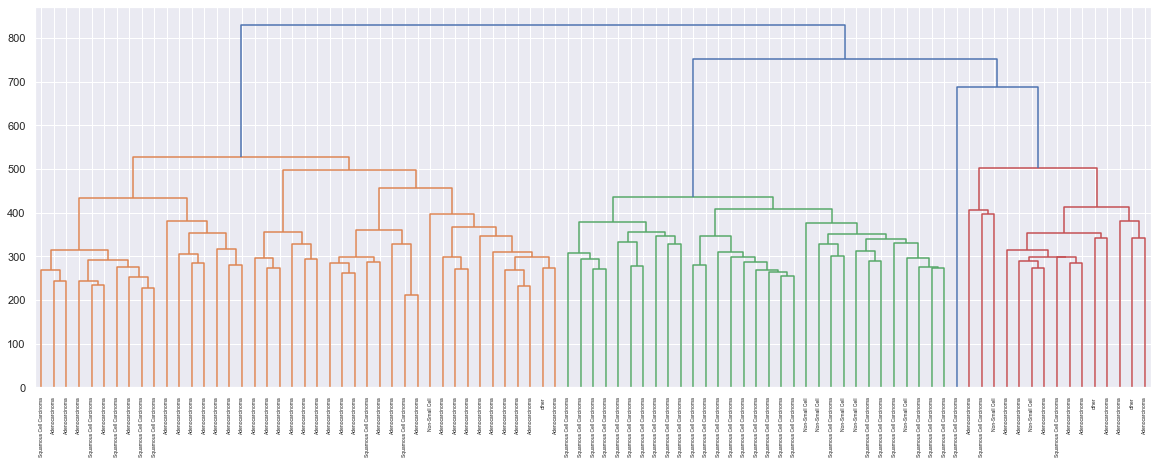

In [72]:
Original = hierarchy.linkage(X, method = 'ward')
plt.figure(figsize= (20, 7))
# Make the dendrogram
den = hierarchy.dendrogram(Original, 
                           truncate_mode = None,
                           labels = labels.hist_tags.values
                          )
plt.show()

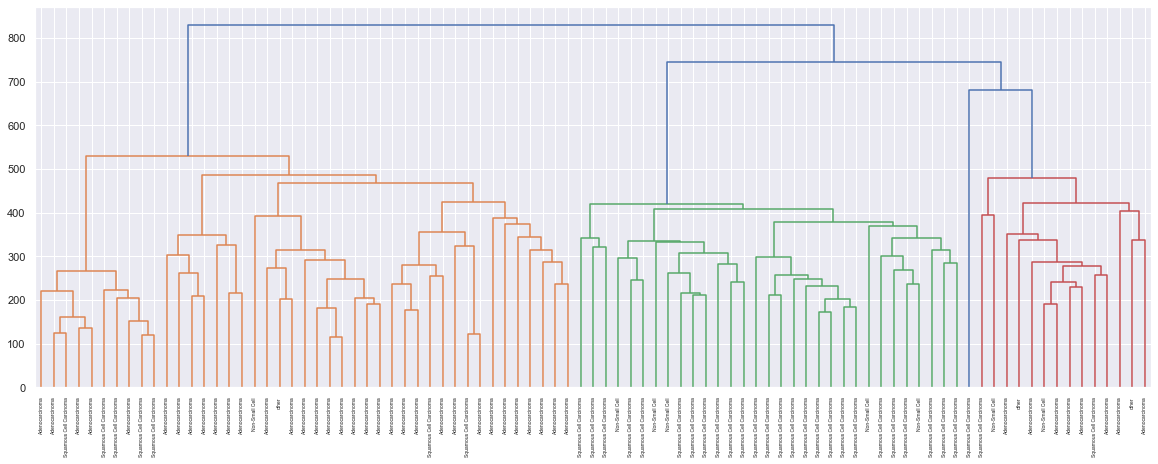

In [74]:
PCA_Based = hierarchy.linkage(principalDf, method = 'ward')
plt.figure(figsize= (20, 7))
# Make the dendrogram
den = hierarchy.dendrogram(PCA_Based, 
                           truncate_mode = None,
                           labels = labels.hist_tags.values
                          )
plt.show()

The yellow cluster is dominated by Adenocarcinoma samples, the green cluster by Squamous carcinoma. The smaller groups and subhistologies are captured in the third and fourth cluster. There seems to be quite some overlap between the subhistology types. Maybe 4 clusters is not the optimal cluster size as well, since the already mentioned types are predominant over the other two. More samples for each group would aid to improve.

Finally: retry kmeans on tSNE for 2 and 3 clusters to come to a final conclusion.

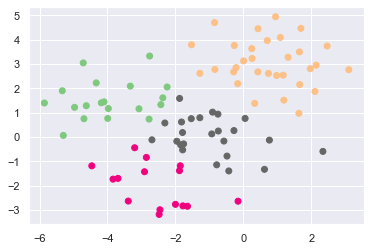

In [75]:
kmeans = KMeans(n_clusters=4, random_state=0, init = 'k-means++')
kTNSE_4 = kmeans.fit_predict(X_embedded)

plt.scatter(x= X_embedded[:,0], y=X_embedded[:,1], c=kTNSE_4, cmap='Accent')

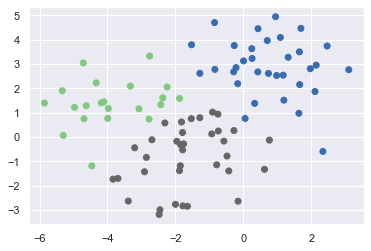

In [76]:
kmeans = KMeans(n_clusters=3, random_state=0, init = 'k-means++')
kTNSE_3 = kmeans.fit_predict(X_embedded)

plt.scatter(x= X_embedded[:,0], y=X_embedded[:,1], c=kTNSE_3, cmap='Accent')

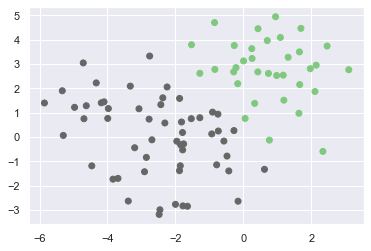

In [77]:
kmeans = KMeans(n_clusters=2, random_state=0, init = 'k-means++')
kTNSE_2 = kmeans.fit_predict(X_embedded)

plt.scatter(x= X_embedded[:,0], y=X_embedded[:,1], c=kTNSE_2, cmap='Accent')

In [79]:
tsne_ev4 = metrics.adjusted_rand_score(kTNSE_4, labels.hist_tags.values)
tsne_ev3 = metrics.adjusted_rand_score(kTNSE_3, labels.hist_tags.values)
tsne_ev2 = metrics.adjusted_rand_score(kTNSE_2, labels.hist_tags.values)

print('Adjusted clustering score kmeans on tSNE with 4 clusters for regrouped labels: {:0.3f}'.format(tsne_ev4))
print('Adjusted clustering score kmeans on tSNE with 3 clusters for regrouped labels: {:0.3f}'.format(tsne_ev3))
print('Adjusted clustering score kmeans on tSNE with 2 clusters for regrouped labels: {:0.3f}'.format(tsne_ev2))

Adjusted clustering score kmeans on tSNE with 4 clusters for regrouped labels: 0.291
Adjusted clustering score kmeans on tSNE with 3 clusters for regrouped labels: 0.378
Adjusted clustering score kmeans on tSNE with 2 clusters for regrouped labels: 0.496


The number of clusters is an important paramter, and as shown here and in hierarchical clustering, the size 4 is not optimal. The kmeans on tSNE has the best performance assumeing 2 clusters.

# Final conclusion

Gene expression data is high dimensional data, which might yield a lot of interesting patterns for future research to unravel. Several aspects on what to investigate in further research are mentioned in the following.

## Choice of dimensionality reduction method
This analysis aimed to test, whether PCA is chosen for valid reason or just because of the general popularity. From the seen results, it performed on comparable level as tSNE and better as using MDS or spectral embedding. PCA seems to be at least not worse than the other available options. However, tSNE might be the better choice on the long run, since there is more potential yielded. In this analysis no parameter tuning (e.g. perplexity) was conducted, which might improve the performance. Moreover UMAP, which is considered to outperform tSNE, especially in omics datasets was not tested. [https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668] 

Another way of reducing dimensionality, which is more on the feature selection side. Gene panels include genes which are characteristic for the tissue of interest. There are gene panels available, which are extended by genes which play a role in certain diseases. For lung cancer plenty of these gene panels are available. Future research could use gene panels to make a pre-selection of genes and then use unsupervised techniques for further investigation. 

## Data
Gene expression datasets are most often characterized by having way more features than samples, which is the exact opposite of what is desirable in machine learning. In this set, 89 samples are present, which is already reasonable high amount of samples for a gene expression study. All samples were used, no matter of there label. From the PCA and spectral clustering visualisation a clear outlier was detected. Removing this outlier and maybe the smallest group would have improved the modelling as well.

## Choice of clustering method
K-Means might not be the optimal algorithm. Further algorithms to test might be OPTICS. 